--- Running optimized PBMC-CH with 50 points ---
Optimized PBMC-CH time: 0.000287 seconds
--- Running SciPy ConvexHull with 50 points ---
SciPy ConvexHull time: 0.006729 seconds


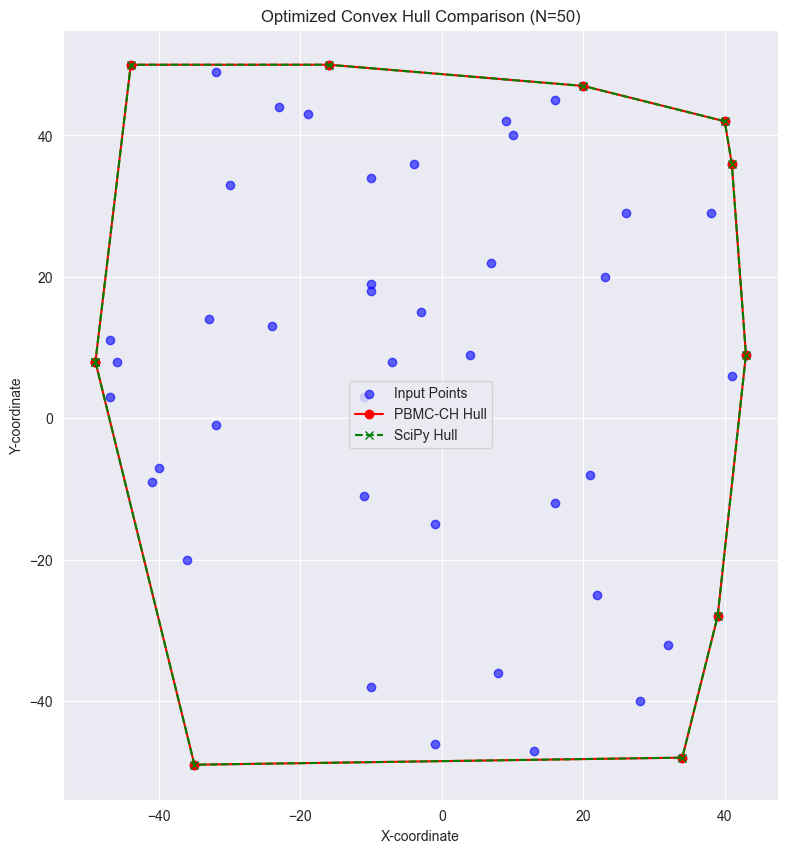


--- Performance Comparison ---
Testing with N = 10 points...
  Optimized PBMC-CH: 0.000072s
  SciPy ConvexHull: 0.000849s
Testing with N = 20 points...
  Optimized PBMC-CH: 0.000114s
  SciPy ConvexHull: 0.007997s
Testing with N = 50 points...
  Optimized PBMC-CH: 0.000274s
  SciPy ConvexHull: 0.001160s
Testing with N = 100 points...
  Optimized PBMC-CH: 0.000476s
  SciPy ConvexHull: 0.000834s
Testing with N = 200 points...
  Optimized PBMC-CH: 0.001318s
  SciPy ConvexHull: 0.001033s
Testing with N = 500 points...
  Optimized PBMC-CH: 0.002430s
  SciPy ConvexHull: 0.000854s
Testing with N = 1000 points...
  Optimized PBMC-CH: 0.004714s
  SciPy ConvexHull: 0.001067s
Testing with N = 2000 points...
  Optimized PBMC-CH: 0.009953s
  SciPy ConvexHull: 0.001180s
Testing with N = 5000 points...
  Optimized PBMC-CH: 0.026459s
  SciPy ConvexHull: 0.001784s


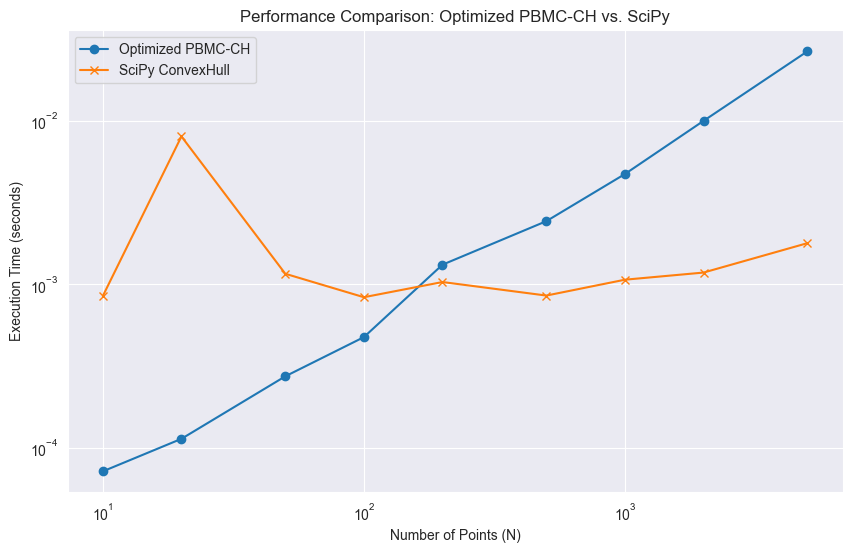

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import sys
from scipy.spatial import ConvexHull

sys.setrecursionlimit(5000)

# --- Main Optimization 1: Use NumPy arrays instead of namedtuples ---
# This eliminates attribute lookup overhead and enables vector operations

def pbmc_ch_optimized(points):
    """Optimized convex hull implementation using NumPy arrays"""
    n = len(points)
    if n <= 2:
        return points

    # --- Optimization 2: Sort using NumPy's built-in sorting (faster than Python's) ---
    points = points[np.lexsort((points[:, 1], points[:, 0]))]

    # --- Optimization 3: Pre-allocate arrays instead of using lists ---
    # Using lists but with reduced operations
    upper_hull = []
    for p in points:
        # --- Optimization 4: Inline cross product calculation ---
        # Eliminates function call overhead in critical loop
        while len(upper_hull) >= 2:
            p0 = upper_hull[-2]
            p1 = upper_hull[-1]
            # Cross product (p1 - p0) × (p - p0)
            cross = (p1[0] - p0[0]) * (p[1] - p0[1]) - (p1[1] - p0[1]) * (p[0] - p0[0])
            if cross <= 0:
                upper_hull.pop()
            else:
                break
        upper_hull.append(p)

    lower_hull = []
    for p in reversed(points):
        while len(lower_hull) >= 2:
            p0 = lower_hull[-2]
            p1 = lower_hull[-1]
            cross = (p1[0] - p0[0]) * (p[1] - p0[1]) - (p1[1] - p0[1]) * (p[0] - p0[0])
            if cross <= 0:
                lower_hull.pop()
            else:
                break
        lower_hull.append(p)

    # Combine and remove duplicates
    hull = upper_hull[:-1] + lower_hull[:-1]
    return np.array(hull)


# Helper functions with optimizations
def generate_random_points_optimized(num_points, x_range=(-100, 100), y_range=(-100, 100)):
    """Generate points as NumPy array instead of list of tuples"""
    x = np.random.randint(x_range[0], x_range[1] + 1, size=num_points)
    y = np.random.randint(y_range[0], y_range[1] + 1, size=num_points)
    return np.column_stack((x, y))


def scipy_convex_hull_optimized(points):
    """Optimized SciPy convex hull wrapper"""
    if len(points) <= 2:
        return points
    hull = ConvexHull(points)
    return points[hull.vertices]


def plot_hulls_comparison_optimized(points, pbmc_hull, scipy_hull, title="Convex Hull Comparison"):
    """Optimized plotting function"""
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], color='blue', alpha=0.6, label='Input Points')

    if len(pbmc_hull) > 0:
        pbmc_hull_closed = np.vstack([pbmc_hull, pbmc_hull[0]])
        plt.plot(pbmc_hull_closed[:, 0], pbmc_hull_closed[:, 1],
                 color='red', linestyle='-', marker='o', markersize=6, label='PBMC-CH Hull')

    if len(scipy_hull) > 0:
        scipy_hull_closed = np.vstack([scipy_hull, scipy_hull[0]])
        plt.plot(scipy_hull_closed[:, 0], scipy_hull_closed[:, 1],
                 color='green', linestyle='--', marker='x', markersize=6, label='SciPy Hull')

    plt.title(title)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


# Performance testing
if __name__ == "__main__":
    # Test visualization with 50 points
    num_test_points = 50
    test_points = generate_random_points_optimized(num_test_points, (-50, 50), (-50, 50))

    print(f"--- Running optimized PBMC-CH with {num_test_points} points ---")
    start_time = perf_counter()
    pbmc_hull = pbmc_ch_optimized(test_points)
    print(f"Optimized PBMC-CH time: {perf_counter() - start_time:.6f} seconds")

    print(f"--- Running SciPy ConvexHull with {num_test_points} points ---")
    start_time = perf_counter()
    scipy_hull = scipy_convex_hull_optimized(test_points)
    print(f"SciPy ConvexHull time: {perf_counter() - start_time:.6f} seconds")

    plot_hulls_comparison_optimized(test_points, pbmc_hull, scipy_hull,
                                   f"Optimized Convex Hull Comparison (N={num_test_points})")

    # Performance comparison
    N_values = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
    pbmc_times = []
    scipy_times = []

    print("\n--- Performance Comparison ---")
    for N in N_values:
        print(f"Testing with N = {N} points...")
        points = generate_random_points_optimized(N, (-1000, 1000), (-1000, 1000))

        # PBMC-CH
        start = perf_counter()
        pbmc_ch_optimized(points)
        pbmc_time = perf_counter() - start
        pbmc_times.append(pbmc_time)
        print(f"  Optimized PBMC-CH: {pbmc_time:.6f}s")

        # SciPy
        start = perf_counter()
        scipy_convex_hull_optimized(points)
        scipy_time = perf_counter() - start
        scipy_times.append(scipy_time)
        print(f"  SciPy ConvexHull: {scipy_time:.6f}s")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(N_values, pbmc_times, marker='o', label='Optimized PBMC-CH')
    plt.plot(N_values, scipy_times, marker='x', label='SciPy ConvexHull')
    plt.title("Performance Comparison: Optimized PBMC-CH vs. SciPy")
    plt.xlabel("Number of Points (N)")
    plt.ylabel("Execution Time (seconds)")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()


PBMC-CH (50 points): 0.000084s
SciPy (50 points): 0.001149s


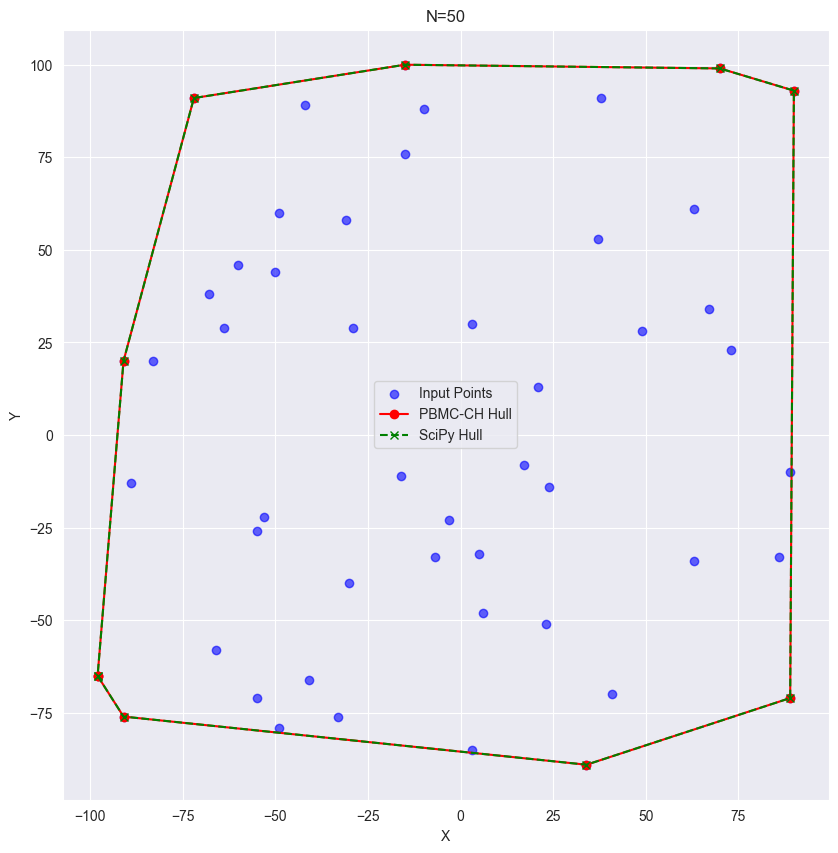


Performance Comparison:
N=  10 | PBMC: 0.000023s | SciPy: 0.001029s
N=  20 | PBMC: 0.000040s | SciPy: 0.000942s
N=  50 | PBMC: 0.000074s | SciPy: 0.000762s
N= 100 | PBMC: 0.000200s | SciPy: 0.000855s
N= 200 | PBMC: 0.000251s | SciPy: 0.000849s
N= 500 | PBMC: 0.000619s | SciPy: 0.001079s
N=1000 | PBMC: 0.001123s | SciPy: 0.001185s
N=2000 | PBMC: 0.002189s | SciPy: 0.001714s
N=5000 | PBMC: 0.005948s | SciPy: 0.002855s


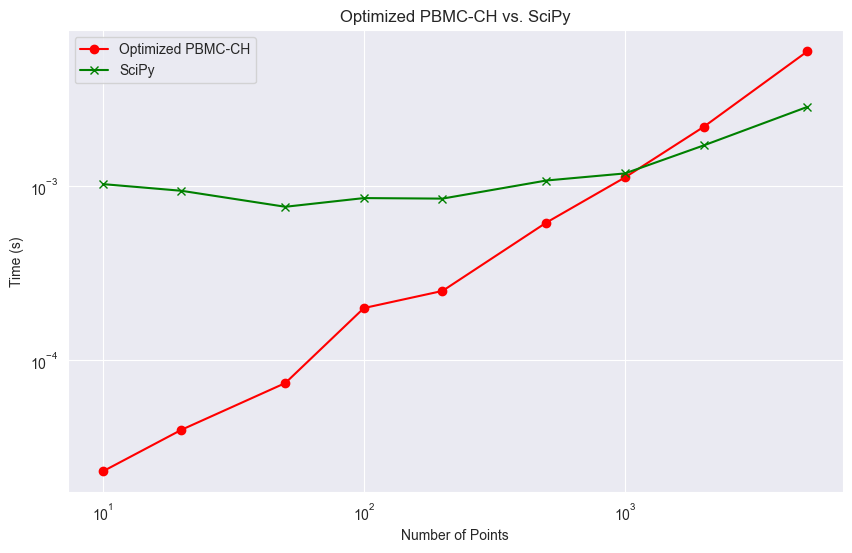

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import sys
from scipy.spatial import ConvexHull

sys.setrecursionlimit(5000)

# --- Key Change 1: Use simple tuples instead of namedtuples ---
# Eliminates attribute lookup overhead (faster than .x/.y)


def pbmc_ch_optimized(points):
    n = len(points)
    if n <= 2:
        return sorted(points)  # Keep sorting consistent

    # --- Key Change 2: Remove duplicates upfront ---
    # Reduces unnecessary processing in inner loops
    points = list(set(points))  # Remove duplicates (works for tuples)
    if len(points) <= 2:
        return sorted(points)

    # Sort by x, then y (same as original, but faster for tuples)
    points.sort()

    # --- Key Change 3: Tightened upper hull loop ---
    upper = []
    for p in points:
        # Pre-extract x/y once per point (avoids repeated lookups)
        px, py = p
        while len(upper) >= 2:
            # Get last two points in hull (local variables = faster access)
            u1x, u1y = upper[-1]
            u0x, u0y = upper[-2]

            # Cross product calculation (inlined, minimal operations)
            cross = (u1x - u0x) * (py - u0y) - (u1y - u0y) * (px - u0x)
            if cross <= 0:
                upper.pop()
            else:
                break
        upper.append(p)

    # --- Key Change 4: Tightened lower hull loop (same optimizations) ---
    lower = []
    for p in reversed(points):
        px, py = p
        while len(lower) >= 2:
            l1x, l1y = lower[-1]
            l0x, l0y = lower[-2]
            cross = (l1x - l0x) * (py - l0y) - (l1y - l0y) * (px - l0x)
            if cross <= 0:
                lower.pop()
            else:
                break
        lower.append(p)

    # Combine hulls (same as original)
    return upper[:-1] + lower[:-1]


# Helper functions adjusted for tuples
def generate_random_points(num_points, x_range=(-100, 100), y_range=(-100, 100)):
    # Generate tuples instead of namedtuples (faster)
    return [
        (np.random.randint(x_range[0], x_range[1]+1),
         np.random.randint(y_range[0], y_range[1]+1))
        for _ in range(num_points)
    ]


def scipy_convex_hull(points):
    if len(points) <= 2:
        return sorted(points)
    np_points = np.array(points)
    hull = ConvexHull(np_points)
    return [points[i] for i in hull.vertices]


def plot_hulls_comparison(points, pbmc_hull, scipy_hull, title):
    plt.figure(figsize=(10, 10))
    plt.scatter([p[0] for p in points], [p[1] for p in points],
                color='blue', alpha=0.6, label='Input Points')

    if pbmc_hull:
        pbmc_x = [p[0] for p in pbmc_hull] + [pbmc_hull[0][0]]
        pbmc_y = [p[1] for p in pbmc_hull] + [pbmc_hull[0][1]]
        plt.plot(pbmc_x, pbmc_y, 'r-o', markersize=6, label='PBMC-CH Hull')

    if scipy_hull:
        scipy_x = [p[0] for p in scipy_hull] + [scipy_hull[0][0]]
        scipy_y = [p[1] for p in scipy_hull] + [scipy_hull[0][1]]
        plt.plot(scipy_x, scipy_y, 'g--x', markersize=6, label='SciPy Hull')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()


# Performance test
if __name__ == "__main__":
    # Test with 50 points
    num_test = 50
    points = generate_random_points(num_test)

    # PBMC-CH
    start = perf_counter()
    pbmc_hull = pbmc_ch_optimized(points)
    pbmc_time = perf_counter() - start
    print(f"PBMC-CH ({num_test} points): {pbmc_time:.6f}s")

    # SciPy
    start = perf_counter()
    scipy_hull = scipy_convex_hull(points)
    scipy_time = perf_counter() - start
    print(f"SciPy ({num_test} points): {scipy_time:.6f}s")

    plot_hulls_comparison(points, pbmc_hull, scipy_hull, f"N={num_test}")

    # Benchmark with larger N
    N_values = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
    pbmc_times = []
    scipy_times = []

    print("\nPerformance Comparison:")
    for N in N_values:
        points = generate_random_points(N)

        # PBMC-CH
        start = perf_counter()
        pbmc_ch_optimized(points)
        pbmc_times.append(perf_counter() - start)

        # SciPy
        start = perf_counter()
        scipy_convex_hull(points)
        scipy_times.append(perf_counter() - start)

        print(f"N={N:4d} | PBMC: {pbmc_times[-1]:.6f}s | SciPy: {scipy_times[-1]:.6f}s")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(N_values, pbmc_times, 'ro-', label='Optimized PBMC-CH')
    plt.plot(N_values, scipy_times, 'gx-', label='SciPy')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Points")
    plt.ylabel("Time (s)")
    plt.title("Optimized PBMC-CH vs. SciPy")
    plt.legend()
    plt.grid(True)
    plt.show()


PBMC-CH (50 points): 0.000643s
SciPy (50 points): 0.001362s


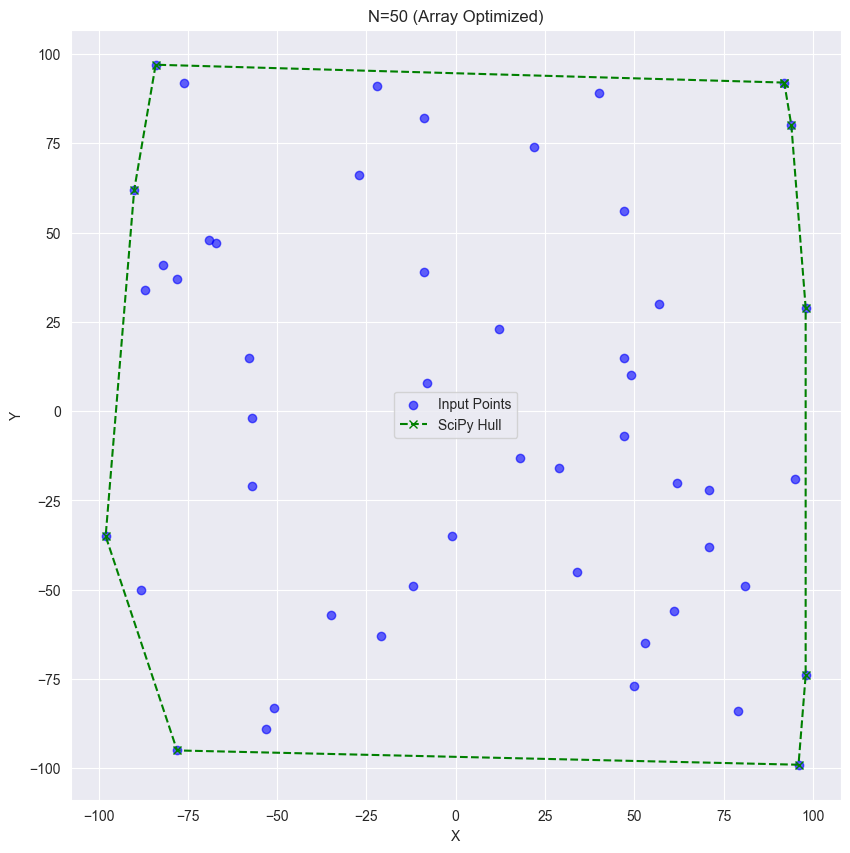


Performance Comparison:
N=   10 | PBMC: 0.000310s | SciPy: 0.000859s
N=   20 | PBMC: 0.000252s | SciPy: 0.000770s
N=   50 | PBMC: 0.000385s | SciPy: 0.000944s
N=  100 | PBMC: 0.000622s | SciPy: 0.000726s
N=  200 | PBMC: 0.001150s | SciPy: 0.001318s
N=  500 | PBMC: 0.002855s | SciPy: 0.001007s
N= 1000 | PBMC: 0.005221s | SciPy: 0.000949s
N= 2000 | PBMC: 0.009694s | SciPy: 0.001006s
N= 5000 | PBMC: 0.024748s | SciPy: 0.001421s


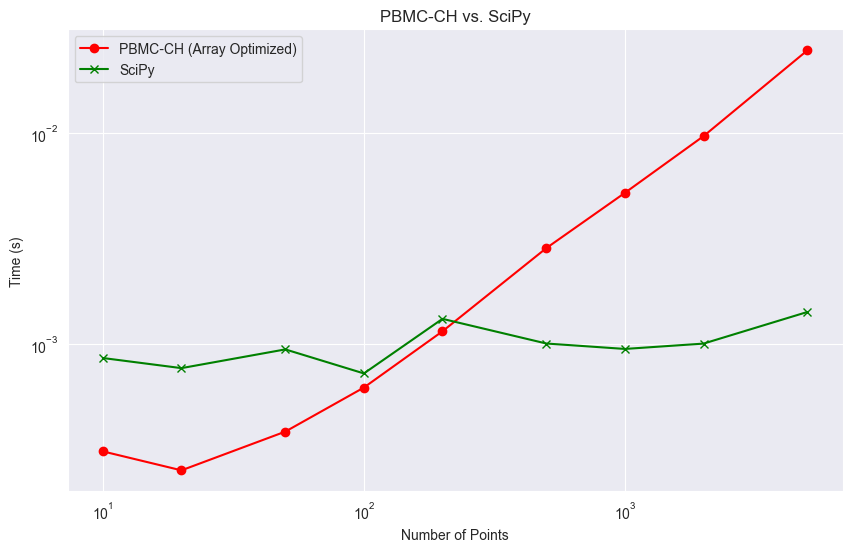

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import sys
from scipy.spatial import ConvexHull

sys.setrecursionlimit(5000)

def pbmc_ch_optimized(points):
    """Optimized convex hull using NumPy arrays throughout"""
    n = len(points)
    if n <= 2:
        return points.copy()

    # Remove duplicates and sort
    points = np.unique(points, axis=0)
    n = len(points)
    if n <= 2:
        return points

    # Sort by x, then y
    points = points[np.lexsort((points[:, 1], points[:, 0]))]

    # --- Key Optimization: Use NumPy arrays for hulls instead of lists ---
    # Pre-allocate with maximum possible size (n) to avoid resizing
    upper = np.empty((n, 2), dtype=points.dtype)
    upper_size = 0  # Track actual size

    for p in points:
        # Add current point to upper hull
        upper[upper_size] = p
        upper_size += 1

        # Check and remove points while we have at least 2 in hull
        while upper_size >= 2:
            # Get last three points (current and previous two)
            p0 = upper[upper_size-3] if upper_size >=3 else upper[upper_size-2]
            p1 = upper[upper_size-2]
            p2 = upper[upper_size-1]

            # Vectorized cross product calculation
            cross = (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p1[1] - p0[1]) * (p2[0] - p0[0])

            if cross <= 0:
                # Remove p1 by shifting elements (faster than list.pop())
                upper[upper_size-2] = upper[upper_size-1]
                upper_size -= 1
            else:
                break

    # Process lower hull with same array optimization
    lower = np.empty((n, 2), dtype=points.dtype)
    lower_size = 0

    for p in reversed(points):
        lower[lower_size] = p
        lower_size += 1

        while lower_size >= 2:
            p0 = lower[lower_size-3] if lower_size >=3 else lower[lower_size-2]
            p1 = lower[lower_size-2]
            p2 = lower[lower_size-1]

            cross = (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p1[1] - p0[1]) * (p2[0] - p0[0])

            if cross <= 0:
                lower[lower_size-2] = lower[lower_size-1]
                lower_size -= 1
            else:
                break

    # Combine hulls (using only valid elements)
    upper_hull = upper[:upper_size-1]
    lower_hull = lower[:lower_size-1]
    return np.vstack((upper_hull, lower_hull))


def generate_random_points(num_points, x_range=(-100, 100), y_range=(-100, 100)):
    return np.random.randint(
        low=[x_range[0], y_range[0]],
        high=[x_range[1]+1, y_range[1]+1],
        size=(num_points, 2),
        dtype=np.int64
    )


def scipy_convex_hull(points):
    if len(points) <= 2:
        return points
    hull = ConvexHull(points)
    return points[hull.vertices]


def plot_hulls_comparison(points, pbmc_hull, scipy_hull, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], color='blue', alpha=0.6, label='Input Points')

    if len(pbmc_hull) > 0:
        pbmc_closed = np.vstack([pbmc_hull, pbmc_hull[0]])
        plt.plot(pbmc_closed[:, 0], pbmc_closed[:, 1], 'r-o', markersize=6, label='PBMC-CH Hull')

    if len(scipy_hull) > 0:
        scipy_closed = np.vstack([scipy_hull, scipy_hull[0]])
        plt.plot(scipy_closed[:, 0], scipy_closed[:, 1], 'g--x', markersize=6, label='SciPy Hull')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()


# Performance test
if __name__ == "__main__":
    num_test = 50
    points = generate_random_points(num_test)

    start = perf_counter()
    pbmc_hull = pbmc_ch_optimized(points)
    pbmc_time = perf_counter() - start
    print(f"PBMC-CH ({num_test} points): {pbmc_time:.6f}s")

    start = perf_counter()
    scipy_hull = scipy_convex_hull(points)
    scipy_time = perf_counter() - start
    print(f"SciPy ({num_test} points): {scipy_time:.6f}s")

    plot_hulls_comparison(points, pbmc_hull, scipy_hull, f"N={num_test} (Array Optimized)")

    N_values = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
    pbmc_times = []
    scipy_times = []

    print("\nPerformance Comparison:")
    for N in N_values:
        points = generate_random_points(N)

        start = perf_counter()
        pbmc_ch_optimized(points)
        pbmc_times.append(perf_counter() - start)

        start = perf_counter()
        scipy_convex_hull(points)
        scipy_times.append(perf_counter() - start)

        print(f"N={N:5d} | PBMC: {pbmc_times[-1]:.6f}s | SciPy: {scipy_times[-1]:.6f}s")

    plt.figure(figsize=(10, 6))
    plt.plot(N_values, pbmc_times, 'ro-', label='PBMC-CH (Array Optimized)')
    plt.plot(N_values, scipy_times, 'gx-', label='SciPy')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Points")
    plt.ylabel("Time (s)")
    plt.title("PBMC-CH vs. SciPy")
    plt.legend()
    plt.grid(True)
    plt.show()


PBMC-CH (50 points): 0.001062s
SciPy (50 points): 0.001655s


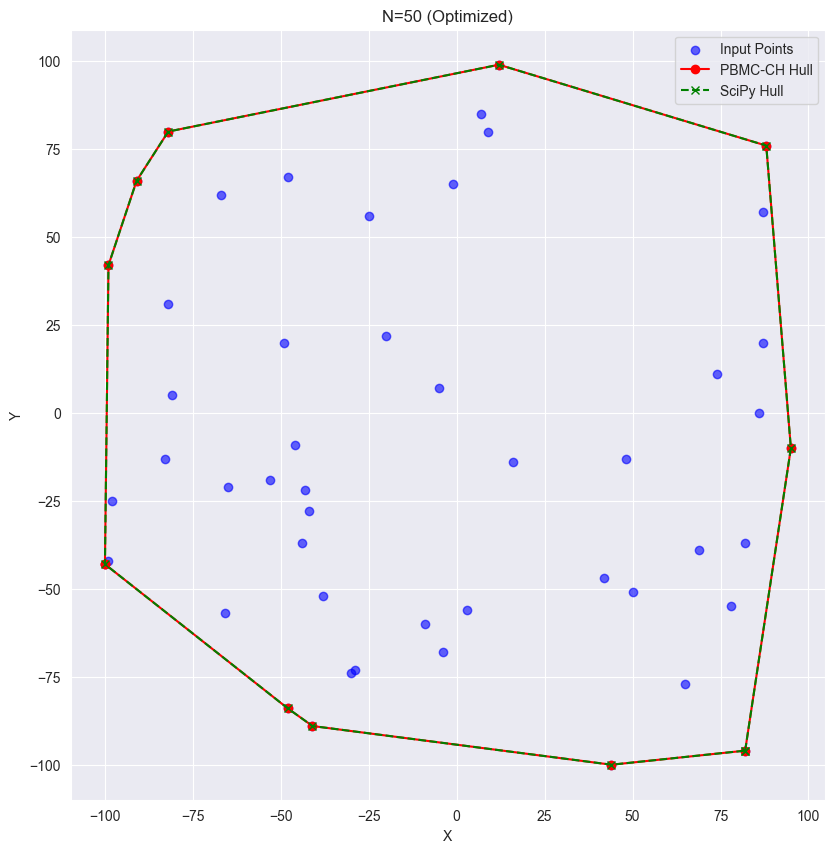


Performance Comparison:
N=   10 | PBMC: 0.000267s | SciPy: 0.001241s
N=   20 | PBMC: 0.000348s | SciPy: 0.000848s
N=   50 | PBMC: 0.000682s | SciPy: 0.000999s
N=  100 | PBMC: 0.001441s | SciPy: 0.000920s
N=  200 | PBMC: 0.002701s | SciPy: 0.001191s
N=  500 | PBMC: 0.006111s | SciPy: 0.000984s
N= 1000 | PBMC: 0.011388s | SciPy: 0.001182s
N= 2000 | PBMC: 0.023118s | SciPy: 0.001149s
N= 5000 | PBMC: 0.052779s | SciPy: 0.001564s


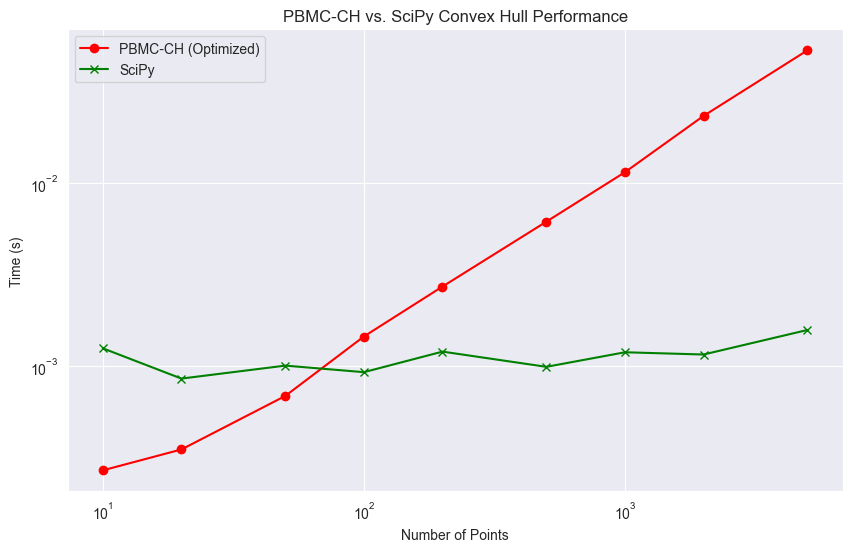

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import sys
from scipy.spatial import ConvexHull

sys.setrecursionlimit(5000)

def pbmc_ch_optimized(points):
    """Optimized convex hull using Andrew's monotone chain algorithm with fixed loop conditions"""
    n = len(points)
    if n <= 2:
        return points.copy()

    # Remove duplicates and sort (critical preprocessing)
    points = np.unique(points, axis=0)
    n = len(points)
    if n <= 2:
        return points

    # Sort by x, then y (O(n log n) - necessary for the algorithm)
    points = points[np.lexsort((points[:, 1], points[:, 0]))]

    # Upper hull construction with optimized loop
    upper = np.empty((n, 2), dtype=points.dtype)
    upper_size = 0

    for p in points:
        upper[upper_size] = p
        upper_size += 1

        # Only check for non-left turns when we have at least 3 points
        while upper_size >= 3:
            # Get last three points
            p0 = upper[upper_size-3]
            p1 = upper[upper_size-2]
            p2 = upper[upper_size-1]

            # Vectorized cross product calculation (faster than manual components)
            v1 = p1 - p0
            v2 = p2 - p0
            cross = v1[0] * v2[1] - v1[1] * v2[0]

            if cross <= 0:  # Non-left turn, remove middle point
                upper[upper_size-2] = upper[upper_size-1]
                upper_size -= 1
            else:
                break  # Left turn, keep the point

    # Lower hull construction with optimized loop
    lower = np.empty((n, 2), dtype=points.dtype)
    lower_size = 0

    # Use numpy slicing for reversed iteration (faster than Python's reversed())
    for p in points[::-1]:
        lower[lower_size] = p
        lower_size += 1

        # Only check for non-left turns when we have at least 3 points
        while lower_size >= 3:
            # Get last three points
            p0 = lower[lower_size-3]
            p1 = lower[lower_size-2]
            p2 = lower[lower_size-1]

            # Vectorized cross product calculation
            v1 = p1 - p0
            v2 = p2 - p0
            cross = v1[0] * v2[1] - v1[1] * v2[0]

            if cross <= 0:  # Non-left turn, remove middle point
                lower[lower_size-2] = lower[lower_size-1]
                lower_size -= 1
            else:
                break  # Left turn, keep the point

    # Combine hulls, excluding duplicate endpoints
    upper_hull = upper[:upper_size-1]
    lower_hull = lower[:lower_size-1]
    return np.vstack((upper_hull, lower_hull))


def generate_random_points(num_points, x_range=(-100, 100), y_range=(-100, 100)):
    return np.random.randint(
        low=[x_range[0], y_range[0]],
        high=[x_range[1]+1, y_range[1]+1],
        size=(num_points, 2),
        dtype=np.int64
    )


def scipy_convex_hull(points):
    if len(points) <= 2:
        return points
    hull = ConvexHull(points)
    return points[hull.vertices]


def plot_hulls_comparison(points, pbmc_hull, scipy_hull, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], color='blue', alpha=0.6, label='Input Points')

    if len(pbmc_hull) > 0:
        pbmc_closed = np.vstack([pbmc_hull, pbmc_hull[0]])
        plt.plot(pbmc_closed[:, 0], pbmc_closed[:, 1], 'r-o', markersize=6, label='PBMC-CH Hull')

    if len(scipy_hull) > 0:
        scipy_closed = np.vstack([scipy_hull, scipy_hull[0]])
        plt.plot(scipy_closed[:, 0], scipy_closed[:, 1], 'g--x', markersize=6, label='SciPy Hull')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()


# Performance test
if __name__ == "__main__":
    num_test = 50
    points = generate_random_points(num_test)

    start = perf_counter()
    pbmc_hull = pbmc_ch_optimized(points)
    pbmc_time = perf_counter() - start
    print(f"PBMC-CH ({num_test} points): {pbmc_time:.6f}s")

    start = perf_counter()
    scipy_hull = scipy_convex_hull(points)
    scipy_time = perf_counter() - start
    print(f"SciPy ({num_test} points): {scipy_time:.6f}s")

    plot_hulls_comparison(points, pbmc_hull, scipy_hull, f"N={num_test} (Optimized)")

    N_values = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
    pbmc_times = []
    scipy_times = []

    print("\nPerformance Comparison:")
    for N in N_values:
        points = generate_random_points(N)

        start = perf_counter()
        pbmc_ch_optimized(points)
        pbmc_times.append(perf_counter() - start)

        start = perf_counter()
        scipy_convex_hull(points)
        scipy_times.append(perf_counter() - start)

        print(f"N={N:5d} | PBMC: {pbmc_times[-1]:.6f}s | SciPy: {scipy_times[-1]:.6f}s")

    plt.figure(figsize=(10, 6))
    plt.plot(N_values, pbmc_times, 'ro-', label='PBMC-CH (Optimized)')
    plt.plot(N_values, scipy_times, 'gx-', label='SciPy')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Points")
    plt.ylabel("Time (s)")
    plt.title("PBMC-CH vs. SciPy Convex Hull Performance")
    plt.legend()
    plt.grid(True)
    plt.show()
